In [297]:
import get_dm_halo
import make_sz_cluster
import make_sz_cluster8
import utils
import read_yaml
import load_vars
from math import e, log

import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd

from astropy.constants import M_sun
from astropy.constants import G
from astropy import units as u

What this notebook currently does: 
- Reads in data from the sim run yaml
- Loads cosmology
- Generates and saves a flat redshift and Mvir distribution as a .txt file
- Loads an existing redshift and Mvir distribution from a .txt file

What this notebook could do, but currently doesn't:
- Generate/use M200 rather than convert from Mvir
- Save m, z dist as .h
- Generates a realistic z, M500 distribution from a given cosmology 

What the modules could be improved to do:
- Streamline the generation of z,M500 distributions by creating a function with options
- Save the z, M500 distribution at the function level in GenerateHalo.py

Problems to be addressed:
- Profile is oddly steep and needs to be checked with Battaglia 2012 realistic z,M, params

In [110]:
ref=read_yaml.YAMLOperator('./inputdata.yaml').parse_yaml() #Read in the .yaml for this simulation run 

In [111]:
(survey,survey_freq,beam_size,noise_level,image_size,pixel_scale)=load_vars.load_vars().make_dict(ref) #Make a dictionary from the .yaml

In [112]:
(cosmo,sigma8,ns)=load_vars.load_vars().flatLCDM(ref) #Make cosmology from yaml input parameters 

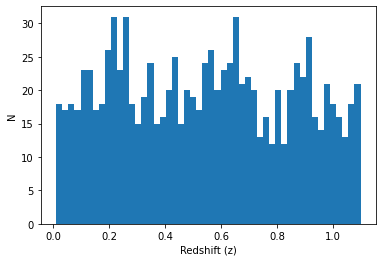

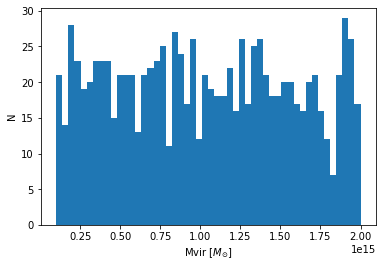

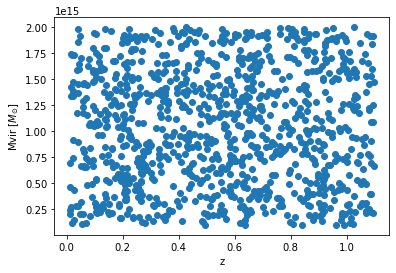

NameError: name 'time' is not defined

In [223]:
#Generate a new flat z, Mvir distribution and save to file: 
halo=get_dm_halo.GenerateHalo() #Load in get_dm_halo class
szcluster=make_sz_cluster.GenerateCluster() #Load in make_sz_cluster class
szcluster2=make_sz_cluster8.GenerateCluster() #Load in make_sz_cluster class
nsources=1000 #Number of halos to generate
zdist,mdist=halo.flatdist_halo(0.01,1.1,1e14,2e15,nsources) #Generate a flat z, Mvir distribution for sims

plt.hist(zdist,bins=50) #Show the z distribution 
plt.ylabel('N'),plt.xlabel('Redshift (z)')
plt.show()
plt.hist(mdist,bins=50) #Show the M500 distribution 
plt.ylabel('N'),plt.xlabel(r'Mvir [$M_{\odot}$]')
plt.show()
plt.plot(zdist,mdist,'o') #Show the z, M500 scatterplot
plt.xlabel('z'),plt.ylabel(r'Mvir [$M_{\odot}$]')
plt.show()

sourceid=int(time.time()) #Create an initial ctime for the halo ID list to save catalog
idlist=[sourceid+x for x in range(len(zdist))] #Create the halo ID list for catalog

np.savetxt('flatmassdist.csv',np.array([zdist,mdist,idlist]).T,delimiter=',') #Save this array to txt

In [131]:
#Load an existing z, M array from txt file
d=np.loadtxt('flatmassdist.csv',delimiter=',') 
zdist=d[:,0]
mdist=d[:,1]
idlist=d[:,2]

OSError: flatmassdist.csv not found.

In [224]:
r=np.linspace(0.01,10,10000) #arcmin
r=utils.arcmin_to_Mpc(r,0.5,cosmo)

In [225]:
z=0.5
Mvir=1.5e13 #solar masses

In [226]:
(M200,R200,c200)=halo.vir_to_200_colossus(cosmo,sigma8,ns,Mvir,z) 
#Convert virial mass to M200 and get R200, concentration from Colossus

In [233]:
P200 = szcluster.P200_Battaglia2012(cosmo,z,M200,R200) #P200 from Battaglia et al. 2012

0.00022540377009625437 keV / cm3
0.3693833109311574


In [309]:
P0=szcluster.param_Battaglia2012(18.1,0.154,-0.758,M200,z) #Parameter computation from Table 1 Battaglia et al. 2012
xc=szcluster.param_Battaglia2012(0.497,-0.00865,0.731,M200,z)
beta=szcluster.param_Battaglia2012(4.35,0.0393,0.415,M200,z)

In [235]:
Pth=szcluster.Pth_Battaglia2012(cosmo,r,z,R200,-0.3,1.0,beta,xc,P0,P200,M200) #Output Battaglia 2012 pressure profile
smth=np.average(Pth)
print(Pth-smth)
lol=(100*(Pth-smth))/smth
print(lol)
print(Pth)

[27.19434154 26.14603803 25.2014677  ... -0.17584534 -0.17584534
 -0.17584534]
[15464.82020224 14868.67319652 14331.51695284 ...   -99.99935387
   -99.99935418   -99.99935449]
[2.73701880e+01 2.63218845e+01 2.53773142e+01 ... 1.13620005e-06
 1.13564908e-06 1.13509842e-06]


In [236]:
Pth_rescaled=(Pth/P200)*(r/R200)**3.
print(np.max(Pth_rescaled))
print(np.min(Pth_rescaled))

527.1695641548753 cm3 / keV
0.4405844772099399 cm3 / keV


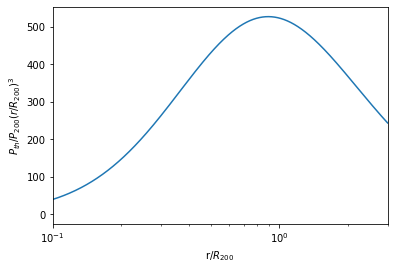

In [43]:
plt.plot(r/R200,Pth_rescaled) #Plot Battaglia 2012 pressure profile: this needs to be checked
plt.xscale('log')
plt.ylabel('$P_{th}/P_{200}(r/R_{200})^3$')
plt.xlabel('r/$R_{200}$')
plt.xlim(.10,3)
plt.show()

In [304]:
x=r/R200
ros=Mvir/((4/3)*np.pi*R200**3)
ro=rho_s/(x*(1+x)**2)
ro_rescaled=ro/rho_s

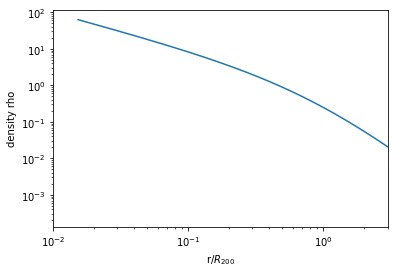

In [305]:
plt.plot(r/R200,ro_rescaled) #Plot Battaglia 2012 pressure profile: this needs to be checked
plt.xscale('log')
plt.yscale('log')
plt.ylabel('density rho')
plt.xlabel('r/$R_{200}$')
plt.xlim(10**-2,3)
plt.show()

In [306]:
cnfw=(5.71*(1+z)**-0.47)*(M200/(2*10**12))**-0.084
Rs=R200/cnfw
rho_s = M200 / ((4*np.pi*Rs**3) * (np.log(1 + cnfw) - cnfw / (1 + cnfw)))
rho_gnfw=(rho_s*(x/xc)**-0.2)*(1+(x/xc)**1)**(-(beta-0.2)/1)
rho_rescaled=rho_gnfw/rho_s

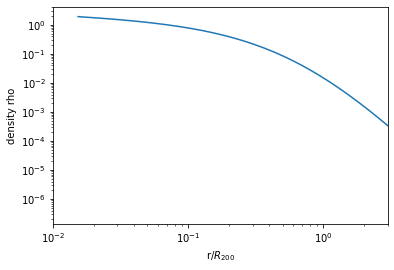

In [307]:
plt.plot(r/R200,rho_rescaled) #Plot NFW profile
plt.xscale('log')
plt.yscale('log')
plt.ylabel('density rho')
plt.xlabel('r/$R_{200}$')
plt.xlim(10**-2,3)
plt.show()